#  Import libraries

In [11]:
import IPython.display as display
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
import numpy as np
import time
import functools

# Download model

In [24]:
import kagglehub
path = kagglehub.model_download("google/arbitrary-image-stylization-v1/tfLite/256-int8-prediction")
print("Path to model files:", path)


  0%|          | 0.00/2.70M [00:00<?, ?B/s]
 37%|███▋      | 1.00M/2.70M [00:01<00:02, 799kB/s]
 74%|███████▍  | 2.00M/2.70M [00:01<00:00, 1.39MB/s]
100%|██████████| 2.70M/2.70M [00:01<00:00, 1.44MB/s]

Path to model files: C:\Users\PMLS\.cache\kagglehub\models\google\arbitrary-image-stylization-v1\tfLite\256-int8-prediction\1


In [25]:
import kagglehub
path = kagglehub.model_download("google/arbitrary-image-stylization-v1/tfLite/256-int8-transfer")
print("Path to model files:", path)


  0%|          | 0.00/278k [00:00<?, ?B/s]
100%|██████████| 278k/278k [00:00<00:00, 306kB/s]

Path to model files: C:\Users\PMLS\.cache\kagglehub\models\google\arbitrary-image-stylization-v1\tfLite\256-int8-transfer\1


# Load & Show images

In [67]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
    img = tf.io.read_file(path_to_img)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
    # Resize the image so that the shorter dimension becomes 256px.
    shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
    short_dim = min(shape)
    scale = target_dim / short_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    image = tf.image.resize(image, new_shape)

    # Central crop the image.
    image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)
    return image

# Load the input images.
content_image = load_img(r"C:\Users\PMLS\Desktop\New folder2\Image Processing & Analysis\Project\c_image.jpg")
style_image =  load_img(r"C:\Users\PMLS\Desktop\New folder2\Image Processing & Analysis\Project\st image.jpg")

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Style Image Shape:', preprocessed_style_image.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

Style Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)


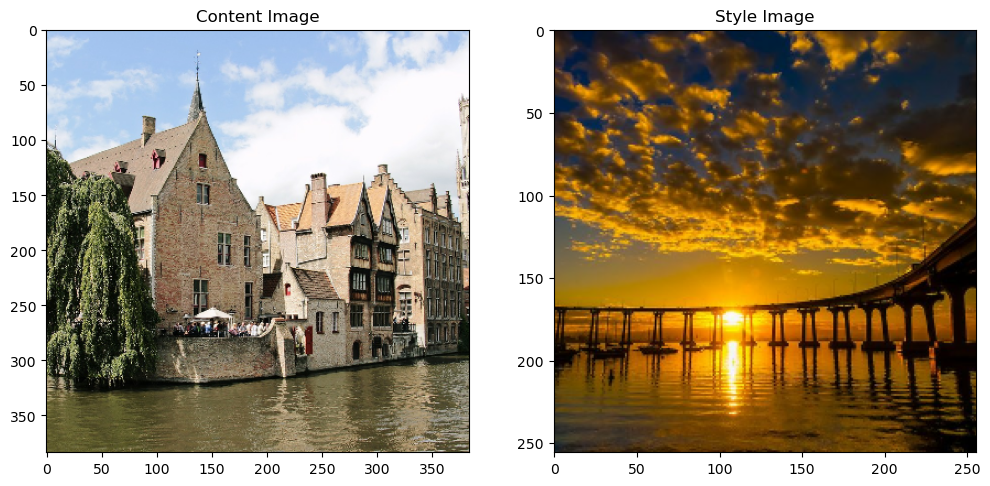

In [68]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image, 'Style Image')

# Style Prediction

In [69]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
    # Load the model.
    interpreter = tf.lite.Interpreter(model_path= r"C:\Users\PMLS\.cache\kagglehub\models\google\arbitrary-image-stylization-v1\tfLite\256-int8-prediction\1\1.tflite")

    # Set model input.
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

    # Calculate style bottleneck.
    interpreter.invoke()
    style_bottleneck = interpreter.tensor(interpreter.get_output_details()[0]["index"])()
    return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)

Style Bottleneck Shape: (1, 1, 1, 100)


# Style Transformation

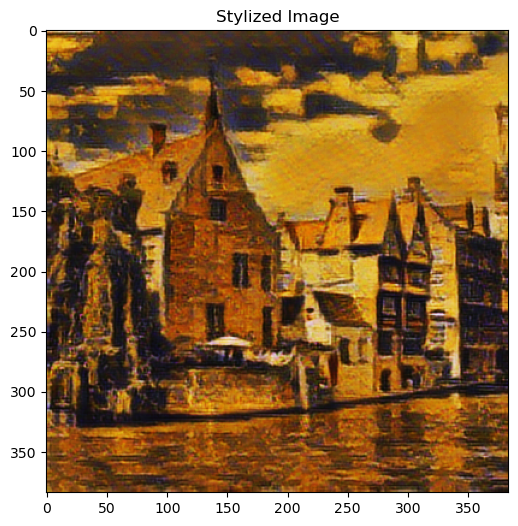

In [79]:
# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
    # Load the model.
    interpreter = tf.lite.Interpreter(model_path= r"C:\Users\PMLS\.cache\kagglehub\models\google\arbitrary-image-stylization-v1\tfLite\256-int8-transfer\1\1.tflite")

    # Set model input.
    input_details = interpreter.get_input_details()
    interpreter.allocate_tensors()

    # Set model inputs.
    interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
    interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
    interpreter.invoke()

    # Transform content image.
    stylized_image = interpreter.tensor(interpreter.get_output_details()[0]["index"])()
    return stylized_image

# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)

new_size = (384, 384)  # Set your desired size here
stylized_image_resized = tf.image.resize(stylized_image, new_size)

import matplotlib.pyplot as plt
# Convert to numpy array and remove any extra dimensions for plotting
stylized_image_resized_np = stylized_image_resized.numpy().squeeze()

# Display the resized image
plt.figure(figsize=(8, 6))
plt.imshow(stylized_image_resized_np)
plt.title('Stylized Image')
plt.show()